In [2111]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2112]:
data_pd = pd.read_csv('/Users/Fabio/Desktop/CMS-SpikingNeuralNetwork/Code/NL0=30_NL1=30_NCl=6_CF01=0.80_CFI0=0.80_CFI1=0.80_alfa=1.00_output.csv') #NEW WORKs
# data_pd = pd.read_csv("NL0=20_NL1=20_NCl=6_CF01=1.00_CFI0=1.00_CFI1=1.00_alfa=0.90_output.csv") #OLD WORKS
data_pd.describe()


,Event,ID,Stream,Time,Pclass
count,12695.000000,12695.000000,12695.000000,1.269500e+04,12695.000000
mean,99758.991650,1.323356,17.732887,6.450880e-07,2.398897
std,143.612531,0.467776,13.847868,3.550915e-07,1.649106
min,99501.000000,1.000000,0.000000,1.420270e-08,0.000000
25%,99637.000000,1.000000,10.000000,3.578610e-07,1.000000
50%,99761.000000,1.000000,14.000000,6.670600e-07,2.000000
75%,99884.000000,2.000000,20.000000,9.469220e-07,4.000000
max,99997.000000,2.000000,59.000000,1.244010e-06,5.000000


In [2113]:
data = dict()
for col in data_pd.columns:
    data[col] = data_pd[col].values

In [2114]:
print(data.keys())

dict_keys(['Event', 'ID', 'Stream', 'Time', 'Pclass'])


Preprocess

In [2115]:
#moltiply data['Stream'] by -1 if it a track (data['id'] == 1)
data['Stream'] = np.where(data['ID'] == 1, -1*data['Stream'], data['Stream'])

Plots

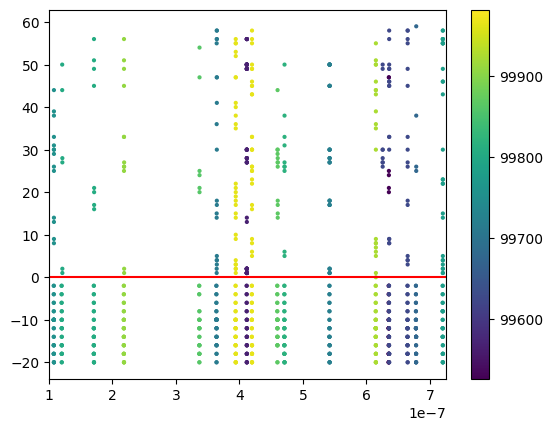

In [2116]:
class_mask = data['Pclass'] == 5
plt.scatter(data['Time'][class_mask], data['Stream'][class_mask],c=data['Event'][class_mask] , s=4)
plt.colorbar()
plt.xlim(1e-7, 7.25e-7)
plt.axhline(0, c = 'r')

In [2117]:
# class_mask_i = data['Pclass'] == 5
# class_mask_j = data['Pclass'] == 4

# plt.scatter(data['Time'][class_mask_i], data['Stream'][class_mask_i], s =4, label = "4")
# plt.scatter(data['Time'][class_mask_j], data['Stream'][class_mask_j], s =4, label = "5")
# plt.legend()
# plt.xlim(2e-7, 4e-7)
# plt.axhline(0, c = 'r')

## Looking at one single event

In [2118]:
N_EV = np.unique(data['Event'][data['Pclass'] == 5])[-11]
N_EV

99818

In [2119]:
#select an event using data_dict['Event']
mask_ev1 = data['Event'] == N_EV

ev1 = {}
for k in data.keys():
    ev1[k] = data[k][mask_ev1]


## Creating the time_track and the time_neur

In [2120]:
t_track = ev1['Time'][ev1['ID'] == 1]
t_track

array([4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07,
       4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07,
       4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07,
       4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07,
       4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07, 4.70784e-07,
       4.70784e-07, 4.70784e-07, 4.70784e-07, 4.71016e-07, 4.71016e-07,
       4.71016e-07, 4.71016e-07])

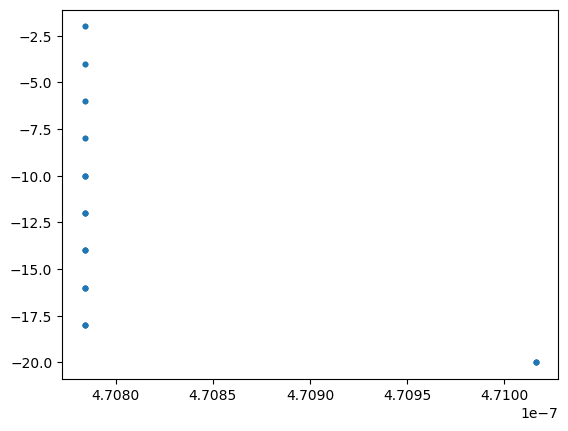

In [2121]:
#plot the track of a single particle
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=10)

In [2122]:
t_neur = ev1['Time'][ev1['ID'] == 2]
t_neur

array([4.71016e-07, 4.71016e-07, 4.71016e-07, 4.71016e-07, 4.71016e-07,
       4.71016e-07, 4.71016e-07, 4.71016e-07, 4.71016e-07, 4.71016e-07])

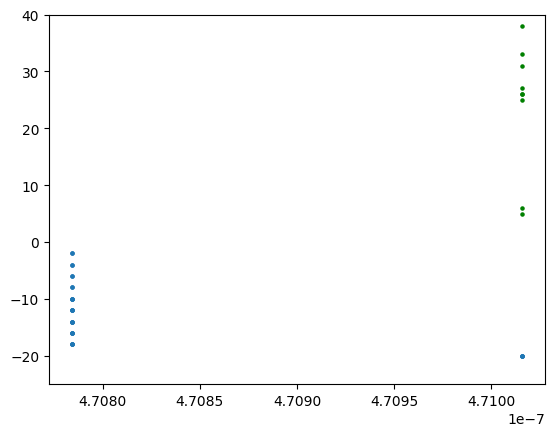

In [2123]:
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=5)
plt.scatter(t_neur, ev1['Stream'][ev1['ID'] == 2], c='g', s = 5)
plt.ylim(-25,40)
plt.show()
#plot the grid on x and y


In [2124]:
hit_neur = ev1['Stream'][ev1['ID'] == 2]
hit_neur

array([25, 26, 38, 26, 27, 50, 31,  5,  6, 33])

In [2125]:
tau = 1e-9

Every spike that arrives induces a change in the membrane potential according to a certain function.\
These changes are smoothed to zero after a time of 7 τ from the arrival of the impulse.\
So, when the neuron receives the last hit of the trace, after a time of 7 τ, the effect of that impulse on the membrane potential is automatically zero.

In [2126]:
min_t_track = np.min(t_track)- 7*tau
max_t_track = np.max(t_track)+ 7*tau

mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)
mask_sel_neur

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

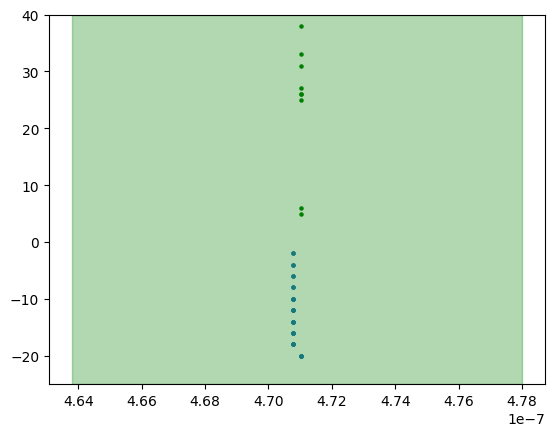

In [2127]:
# now the same plt but with filled zoned in red where i excluded the points
plt.scatter(t_track, ev1['Stream'][ev1['ID'] == 1], s=5)
plt.scatter(t_neur[mask_sel_neur], hit_neur[mask_sel_neur], c='g', s = 5)
plt.ylim(-25,40)
plt.axvspan(min_t_track, max_t_track, alpha=0.3, color='green')

plt.show()


In [2128]:
#Using min_t_track and max_t_track,let's bin in 10 bins the time interval and put the hits of neuron inside the bins
n_bins = 40
bins = np.arange(1, n_bins+1)
print(bins.shape)
print(bins)
hist_y, bin_edges_y = np.histogram(hit_neur[mask_sel_neur], bins=bins)
hist_y



(40,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

## For All Events

In [2129]:
def get_hist_neuron(N_EV, data, N_NEUR):

    """
    This function returns the histogram of the neuron hits inside the track of the particle
    """
    #select an event using data_dict['Event']
    mask_ev1 = data['Event'] == N_EV
    
    ev1 = {}

    for k in data.keys():
        ev1[k] = data[k][mask_ev1]

    t_track = ev1['Time'][ev1['ID'] == 1]

    t_neur = ev1['Time'][ev1['ID'] == 2]
    hit_neur = ev1['Stream'][ev1['ID'] == 2]

    min_t_track = np.min(t_track) - 0.01e-7
    max_t_track = np.max(t_track) + 0.01e-7
    mask_sel_neur = np.logical_and(t_neur>min_t_track, t_neur<max_t_track)

    bins = np.arange(0, N_NEUR+1)

    #now check if inside the t_neuron there are values inside the bins
    hist, bin_edges = np.histogram(hit_neur[mask_sel_neur], bins=bins)

    return hist


In [2130]:
N_EV_class0 = np.unique(data['Event'][data['Pclass'] == 0])
N_EV_class1 = np.unique(data['Event'][data['Pclass'] == 1])
N_EV_class2 = np.unique(data['Event'][data['Pclass'] == 2])
N_EV_class3 = np.unique(data['Event'][data['Pclass'] == 3])
N_EV_class4 = np.unique(data['Event'][data['Pclass'] == 4])
N_EV_class5 = np.unique(data['Event'][data['Pclass'] == 5])

In [2131]:
for EV in N_EV_class5:
    print(get_hist_neuron(EV, data,40))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 9 9 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 6 0 0 0 0 0 0
 0 0 0]
[1 2 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 2 3 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1
 0 1 0]
[1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 1 1]
[0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0
 0 0 0]
[0 0 0 1 2 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 0]
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 5 0 0 0 0 0 0
 0 0 0]
[0 1 1 1 2 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 0]
[0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 3 3 0 4 0 0 0 0 0 0
 0 0 0]
[0 0

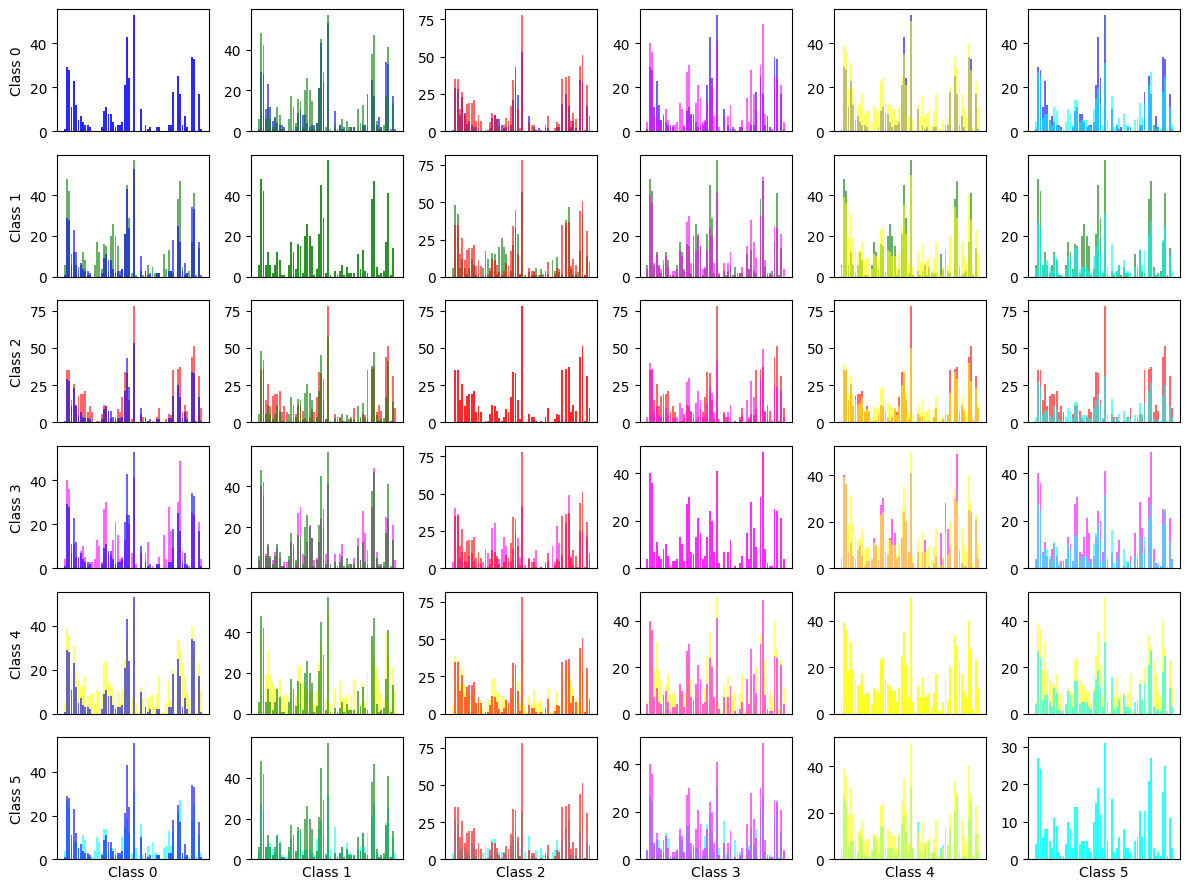

In [2132]:
N_NEUR = 60 

hist0 = np.zeros(N_NEUR)
hist1 = np.zeros(N_NEUR)
hist2 = np.zeros(N_NEUR)
hist3 = np.zeros(N_NEUR)
hist4 = np.zeros(N_NEUR)
hist5 = np.zeros(N_NEUR)

H0 = []
H1 = []
H2 = []
H3 = []
H4 = []
H5 = []

for EV in N_EV_class0:
    hist0 = hist0 + get_hist_neuron(EV, data,N_NEUR)
    H0.append(get_hist_neuron(EV, data,N_NEUR))


for EV in N_EV_class1:
    hist1 = hist1 + get_hist_neuron(EV, data,N_NEUR)
    H1.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class2:
    hist2 = hist2 + get_hist_neuron(EV, data,N_NEUR)
    H2.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class3:
    hist3 = hist3 + get_hist_neuron(EV, data,N_NEUR)
    H3.append(get_hist_neuron(EV, data,N_NEUR))




for EV in N_EV_class4:
    hist4 = hist4 + get_hist_neuron(EV, data,N_NEUR)
    H4.append(get_hist_neuron(EV, data,N_NEUR))



for EV in N_EV_class5:
    hist5 = hist5 + get_hist_neuron(EV, data,N_NEUR)
    H5.append(get_hist_neuron(EV, data,N_NEUR))


HISTS = [hist0, hist1, hist2, hist3, hist4, hist5]
HISTS = np.array(HISTS)

COLORS = ['b', 'g', 'r', 'magenta', 'yellow', 'cyan']

#Now create a matrix plot comparing hist_i and hist_j
plt.subplots(6,6, figsize=(12,9))
for i in range(6):
    for j in range(6):
        plt.subplot(6,6,6*i+j+1)
        plt.bar(np.arange(len(HISTS[i])),HISTS[i], color = COLORS[i], alpha = 0.6)
        plt.bar(np.arange(len(HISTS[j])),HISTS[j], color = COLORS[j], alpha = 0.6)
        plt.xticks([])

        #I want the labels only on the right and on the top
        if j == 0:
            plt.ylabel('Class {}'.format(i))
        if i == 5:
            plt.xlabel('Class {}'.format(j))
        #plot the axes on every histo

            

plt.tight_layout()

# PCA analysis

In [2133]:
H = H0 + H1 + H2 + H3 + H4 + H5

label = []
for i in range(len(H0)):
    label.append(0)
for i in range(len(H1)):
    label.append(1)
for i in range(len(H2)):
    label.append(2)
for i in range(len(H3)):
    label.append(3)
for i in range(len(H4)):
    label.append(4)
for i in range(len(H5)):
    label.append(5)

label = np.array(label)


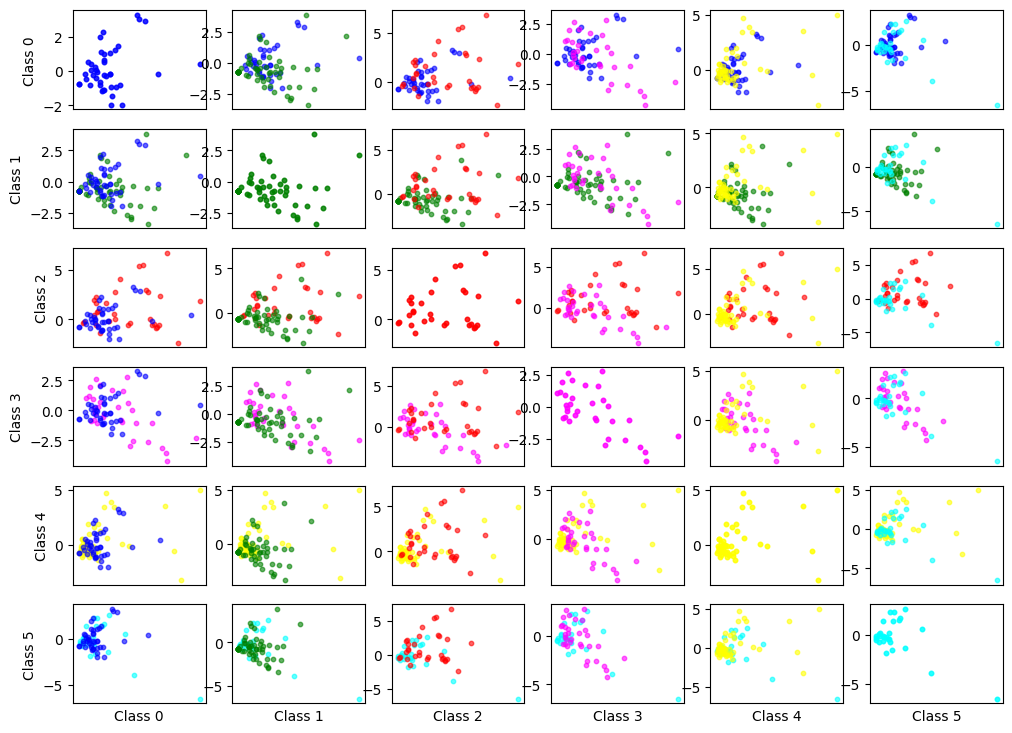

In [2134]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
data_pca = pca.fit_transform(H)


# Plot dei dati
#create matric plot comparic 2 label aech time
plt.subplots(6,6, figsize=(12,9))
for i in range(6):
    for j in range(6):
        plt.subplot(6,6,6*i+j+1)
        plt.scatter(data_pca[:, 0][label == i], data_pca[:, 1][label == i], c = COLORS[i], alpha = 0.6, s = 10)
        plt.scatter(data_pca[:, 0][label == j], data_pca[:, 1][label == j], c = COLORS[j], alpha = 0.6, s = 10)
        plt.xticks([])

        #I want the labels only on the right and on the top
        if j == 0:
            plt.ylabel('Class {}'.format(i))
        if i == 5:
            plt.xlabel('Class {}'.format(j))
        #plot the axes on every histo





plt.show()


## Next Steps

The things that can be improved are:
1. Consider the temporal order of firing, which has not been done here.